# Linear Regression - Predict Housing Prices


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Linear regression with one variable ](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2  Dataset](#2.2)
  - [ 2.3 Refresher on linear regression](#2.3)
  - [ 2.4  Compute Cost](#2.4)
    - [ Exercise 1](#ex01)
  - [ 2.5 Gradient descent ](#2.5)
    - [ Exercise 2](#ex02)
  - [ 2.6 Learning parameters using batch gradient descent ](#2.6)


<a name="1"></a>
## 1 - Packages 

- [numpy](www.numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- ``utils.py`` contains helper functions for this assignment. You do not need to modify code in this file.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math


## 2 -  Problem Statement

Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet.
- You would like to expand your business to cities that may give your restaurant higher profits.
- The chain already has restaurants in various cities and you have data for profits and populations from the cities.
- You also have data on cities that are candidates for a new restaurant. 
    - For these cities, you have the city population.
    
Can you use the data to help you identify which cities may potentially give your business higher profits?

## 3 - Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `x_train` and `y_train`
  - `x_train` is the population of a city
  - `y_train` is the profit of a restaurant in that city. A negative value for profit indicates a loss.   
  - Both `X_train` and `y_train` are numpy arrays.

In [70]:
from utils import load_data

try:
    # Load the dataset
    data = load_data('/Users/tetianakravchuk/Desktop/CourseraProjects/PredictHousingPrices/PredictHousingPrices/HousingPrices.csv')
    if data is not None and not data.empty:
        x_train, y_train = data
        
        print("Data loaded successfully!")
        print("First 5 x_train values:", x_train[:10])
        print("First 5 y_train values:", y_train[:10])
    else:
        print("Failed to load data: load_data returned None.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except ImportError:
    print("Error: Required library for reading Excel files (e.g., openpyxl) is not installed.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data loaded successfully!
First 5 x_train values: Population
First 5 y_train values: Profit


#### View the variables

The code below prints the variable `x_train` and the type of the variable.

In [78]:
# Ensure data is loaded and check if it's empty
if data is not None and not data.empty:
    x_train, y_train = data['Population'], data['Profit']
    print("Type of x_train:", type(x_train))
    print("First five elements of x_train are:\n", x_train[:10])
else:
    print("Data is not loaded or the DataFrame is empty. Please check the load_data function.")

Type of x_train: <class 'pandas.core.series.Series'>
First five elements of x_train are:
 0      500000
1      600000
2    50000000
3       63455
4      345930
5      235592
6    29930433
7    29944334
8    34990002
9     4990304
Name: Population, dtype: int64


`x_train` is a numpy array that contains decimal values that are all greater than zero.
- These values represent the city population times 10,000
- For example, 6.1101 means that the population for that city is 61,101
  
Now, let's print `y_train`

In [79]:
# Extract y_train from the data DataFrame
y_train = data['Profit'].values

# print y_train
print("Type of y_train:",type(y_train))
print("First five elements of y_train are:\n", y_train[:10])  

Type of y_train: <class 'numpy.ndarray'>
First five elements of y_train are:
 [    6000    43322   454545 34342343   344213    90444    32324    23242
     2324    42424]


Similarly, `y_train` is a numpy array that has decimal values, some negative, some positive.
- These represent your restaurant's average monthly profits in each city, in units of \$10,000.
  - For example, 17.592 represents \$175,920 in average monthly profits for that city.
  - -2.6807 represents -\$26,807 in average monthly loss for that city.

#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions.

Please print the shape of `x_train` and `y_train` and see how many training examples you have in your dataset.

In [84]:
print ('The shape of x_train is:', x_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(x_train))

The shape of x_train is: (11,)
The shape of y_train is:  (11,)
Number of training examples (m): 11


#### Visualize your data

It is often useful to understand the data by visualizing it. 
- For this dataset, we can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). 
- Many other problems that you will encounter in real life have more than two properties (for example, population, average household income, monthly profits, monthly sales).When you have more than two properties, you can still use a scatter plot to see the relationship between each pair of properties.


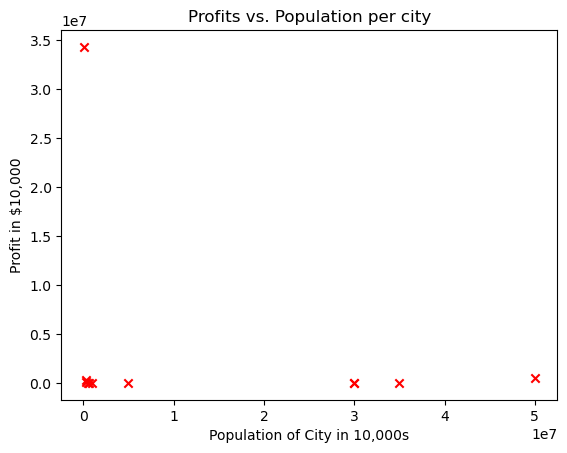

In [91]:
# Create a scatter plot of the data. To change the markers to red "x",
# we used the 'marker' and 'c' parameters
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')
plt.show()

The goal is to build a linear regression model to fit this data.
- With this model, you can then input a new city's population, and have the model estimate your restaurant's potential monthly profits for that city.

<a name="4"></a>
## 4 - Refresher on linear regression

In this practice lab, we will fit the linear regression parameters $(w,b)$ to the dataset.
- The model function for linear regression, which is a function that maps from `x` (city population) to `y` (restaurant's monthly profit for that city) is represented as 
    $$f_{w,b}(x) = wx + b$$
    

- To train a linear regression model, we want to find the best $(w,b)$ parameters that fit the dataset.  

    - To compare how one choice of $(w,b)$ is better or worse than another choice, we can evaluate it with a cost function $J(w,b)$
      - $J$ is a function of $(w,b)$. That is, the value of the cost $J(w,b)$ depends on the value of $(w,b)$.
  
    - The choice of $(w,b)$ that fits your data the best is the one that has the smallest cost $J(w,b)$.


- To find the values $(w,b)$ that gets the smallest possible cost $J(w,b)$, we can use a method called **gradient descent**. 
  - With each step of gradient descent, the parameters $(w,b)$ come closer to the optimal values that will achieve the lowest cost $J(w,b)$.
  

- The trained linear regression model can then take the input feature $x$ (city population) and output a prediction $f_{w,b}(x)$ (predicted monthly profit for a restaurant in that city).

<a name="5"></a>
## 5 - Compute Cost

Gradient descent involves repeated steps to adjust the value of parameter $(w,b)$ to gradually get a smaller and smaller cost $J(w,b)$.
- At each step of gradient descent, it will be helpful to monitor the progress by computing the cost $J(w,b)$ as $(w,b)$ gets updated. 
- In this section, we will implement a function to calculate $J(w,b)$ so that we can check the progress of your gradient descent implementation.

#### Cost function


$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$ 

-  $f_{w,b}(x^{(i)})$ as the model's prediction of your restaurant's profit, as opposed to $y^{(i)}$, which is the actual profit that is recorded in the data.
- $m$ is the number of training examples in the dataset

#### Model prediction

- For linear regression with one variable, the prediction of the model $f_{w,b}$ for an example $x^{(i)}$ is representented as:

$$ f_{w,b}(x^{(i)}) = wx^{(i)} + b$$

This is the equation for a line, with an intercept $b$ and a slope $w$

#### Implementation

`compute_cost()` function below to compute the cost $J(w,b)$.

<a name="ex01"></a>
### Example 1

`compute_cost`:

* We have to iterate over the training examples, and for each example, compute:
    * The prediction of the model for that example 
    $$
    f_{wb}(x^{(i)}) =  wx^{(i)} + b 
    $$
   
    * The cost for that example  $$cost^{(i)} =  (f_{wb} - y^{(i)})^2$$
    

* Return the total cost over all examples
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} cost^{(i)}$$
  * Here, $m$ is the number of training examples and $\sum$ is the summation operator


In [94]:


def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
        x (ndarray): Shape (m,) Input to the model (Population of cities) 
        y (ndarray): Shape (m,) Label (Actual profits for the cities)
        w, b (scalar): Parameters of the model
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    # You need to return this variable correctly
    total_cost = 0
    # Loop over each training example
    for i in range(m):
        # he prediction for the current example
        f_wb = w * x[i] + b
        # Compute the squared error for the current example
        cost_i = (f_wb - y[i]) ** 2
        # Add the squared error to the total cost
        total_cost += cost_i
    
    # Scale the total cost by 1 / (2m)
    total_cost = total_cost / (2 * m)

    return total_cost

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
   * You can represent a summation operator eg: $h = \sum\limits_{i = 0}^{m-1} 2i$ in code as follows:
    
    ```python 
    h = 0
    for i in range(m):
        h = h + 2*i
    ```
  
   * In this case, you can iterate over all the examples in `x` using a for loop and add the `cost` from each iteration to a variable (`cost_sum`) initialized outside the loop.

   * Then, you can return the `total_cost` as `cost_sum` divided by `2m`.
   * If you are new to Python, please check that your code is properly indented with consistent spaces or tabs. Otherwise, it might produce a different output or raise an `IndentationError: unexpected indent` error. You can refer to [this topic](https://community.deeplearning.ai/t/indentation-in-python-indentationerror-unexpected-indent/159398) in our community for details.

    <details>
          <summary><font size="2" color="darkblue"><b> Click for more hints</b></font></summary>
        
    * Here's how you can structure the overall implementation for this function
    
    ```python 
    def compute_cost(x, y, w, b):
        # number of training examples
        m = x.shape[0] 
    
        # You need to return this variable correctly
        total_cost = 0
    
        ### START CODE HERE ###  
        # Variable to keep track of sum of cost from each example
        cost_sum = 0
    
        # Loop over training examples
        for i in range(m):
            # Your code here to get the prediction f_wb for the ith example
            f_wb = 
            # Your code here to get the cost associated with the ith example
            cost = 
        
            # Add to sum of cost for each example
            cost_sum = cost_sum + cost 

        # Get the total cost as the sum divided by (2*m)
        total_cost = (1 / (2 * m)) * cost_sum
        ### END CODE HERE ### 

        return total_cost
    ```
    
    * If you're still stuck, you can check the hints presented below to figure out how to calculate `f_wb` and `cost`.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate f_wb</b></font></summary>
           &emsp; &emsp; For scalars $a$, $b$ and $c$ (<code>x[i]</code>, <code>w</code> and <code>b</code> are all scalars), you can calculate the equation $h = ab + c$ in code as <code>h = a * b + c</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f</b></font></summary>
               &emsp; &emsp; You can compute f_wb as <code>f_wb = w * x[i] + b </code>
           </details>
    </details>

     <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate cost</b></font></summary>
          &emsp; &emsp; You can calculate the square of a variable z as z**2
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate cost</b></font></summary>
              &emsp; &emsp; You can compute cost as <code>cost = (f_wb - y[i]) ** 2</code>
          </details>
    </details>
        
    </details>

</details>

    


You can check if your implementation was correct by running the following test code:

In [105]:
# Compute cost with some initial values for paramaters w, b
initial_w = 2
initial_b = 1

cost = compute_cost(x_train, y_train, initial_w, initial_b)
print(type(cost))
print(f'Cost at initial w: {cost:.3f}')

# Public tests
import sys
import os

# Add the directory containing public_tests to the system path
sys.path.append('/Users/tetianakravchuk/Desktop/CourseraProjects/PredictHousingPrices/PredictHousingPrices')

try:
	from public_tests import *
	compute_cost_test(compute_cost)
except ModuleNotFoundError:
	print("public_tests module not found. Please ensure it is in the project directory.")
except ImportError:
	print("Error: Required library for public tests is not installed.")

<class 'numpy.float64'>
Cost at initial w: 1056595166497632.750
public_tests module not found. Please ensure it is in the project directory.


**Expected Output**:
<table>
  <tr>
    <td> <b>Cost at initial w:<b> 75.203 </td> 
  </tr>
</table>

<a name="6"></a>
## 6 - Gradient descent 

In this section, we will implement the gradient for parameters $w, b$ for linear regression. 

As described in the lecture videos, the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & \phantom {0000} b := b -  \alpha \frac{\partial J(w,b)}{\partial b} \newline       \; & \phantom {0000} w := w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{1}  \; & 
\newline & \rbrace\end{align*}$$

where, parameters $w, b$ are both updated simultaniously and where  
$$
\frac{\partial J(w,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{2}
$$
$$
\frac{\partial J(w,b)}{\partial w}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) -y^{(i)})x^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{w,b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$, is the target value


You will implement a function called `compute_gradient` which calculates $\frac{\partial J(w)}{\partial w}$, $\frac{\partial J(w)}{\partial b}$ 

<a name="ex02"></a>
### Exercise 2

Please complete the `compute_gradient` function to:

* Iterate over the training examples, and for each example, compute:
    * The prediction of the model for that example 
    $$
    f_{wb}(x^{(i)}) =  wx^{(i)} + b 
    $$
   
    * The gradient for the parameters $w, b$ from that example 
        $$
        \frac{\partial J(w,b)}{\partial b}^{(i)}  =  (f_{w,b}(x^{(i)}) - y^{(i)}) 
        $$
        $$
        \frac{\partial J(w,b)}{\partial w}^{(i)}  =  (f_{w,b}(x^{(i)}) -y^{(i)})x^{(i)} 
        $$
    

* Return the total gradient update from all the examples
    $$
    \frac{\partial J(w,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} \frac{\partial J(w,b)}{\partial b}^{(i)}
    $$
    
    $$
    \frac{\partial J(w,b)}{\partial w}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} \frac{\partial J(w,b)}{\partial w}^{(i)} 
    $$
  * Here, $m$ is the number of training examples and $\sum$ is the summation operator

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [108]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
    """
    
    # Number of training examples
    m = x.shape[0]
    
    # Initialize gradients
    dj_dw = 0
    dj_db = 0
    
    # Loop over each training example
    for i in range(m):
        # Compute the prediction for the current example
        f_wb = w * x[i] + b
        
        # Compute the error for the current example
        error = f_wb - y[i]
        
        # Accumulate the gradients
        dj_dw += error * x[i]
        dj_db += error
    
    # Average gradients over all examples
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    
    return dj_dw, dj_db

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
   * You can represent a summation operator eg: $h = \sum\limits_{i = 0}^{m-1} 2i$ in code as follows:
    
   ```python 
    h = 0
    for i in range(m):
        h = h + 2*i
   ```
    
   * In this case, you can iterate over all the examples in `x` using a for loop and for each example, keep adding the gradient from that example to the variables `dj_dw` and `dj_db` which are initialized outside the loop. 

   * Then, you can return `dj_dw` and `dj_db` both divided by `m`.    
    <details>
          <summary><font size="2" color="darkblue"><b> Click for more hints</b></font></summary>
        
    * Here's how you can structure the overall implementation for this function
    
    ```python 
    def compute_gradient(x, y, w, b): 
        """
        Computes the gradient for linear regression 
        Args:
          x (ndarray): Shape (m,) Input to the model (Population of cities) 
          y (ndarray): Shape (m,) Label (Actual profits for the cities)
          w, b (scalar): Parameters of the model  
        Returns
          dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
          dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
        """
    
        # Number of training examples
        m = x.shape[0]
    
        # You need to return the following variables correctly
        dj_dw = 0
        dj_db = 0
    
        ### START CODE HERE ### 
        # Loop over examples
        for i in range(m):  
            # Your code here to get prediction f_wb for the ith example
            f_wb = 
            
            # Your code here to get the gradient for w from the ith example 
            dj_dw_i = 
        
            # Your code here to get the gradient for b from the ith example 
            dj_db_i = 
     
            # Update dj_db : In Python, a += 1  is the same as a = a + 1
            dj_db += dj_db_i
        
            # Update dj_dw
            dj_dw += dj_dw_i
    
        # Divide both dj_dw and dj_db by m
        dj_dw = dj_dw / m
        dj_db = dj_db / m
        ### END CODE HERE ### 
        
        return dj_dw, dj_db
    ```
        
    * If you're still stuck, you can check the hints presented below to figure out how to calculate `f_wb` and `cost`.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate f_wb</b></font></summary>
           &emsp; &emsp; You did this in the previous exercise! For scalars $a$, $b$ and $c$ (<code>x[i]</code>, <code>w</code> and <code>b</code> are all scalars), you can calculate the equation $h = ab + c$ in code as <code>h = a * b + c</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f</b></font></summary>
               &emsp; &emsp; You can compute f_wb as <code>f_wb = w * x[i] + b </code>
           </details>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_dw_i</b></font></summary>
           &emsp; &emsp; For scalars $a$, $b$ and $c$ (<code>f_wb</code>, <code>y[i]</code> and <code>x[i]</code> are all scalars), you can calculate the equation $h = (a - b)c$ in code as <code>h = (a-b)*c</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f</b></font></summary>
               &emsp; &emsp; You can compute dj_dw_i as <code>dj_dw_i = (f_wb - y[i]) * x[i] </code>
           </details>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_db_i</b></font></summary>
             &emsp; &emsp; You can compute dj_db_i as <code> dj_db_i = f_wb - y[i] </code>
    </details>
        
    </details>

</details>

    


Run the cells below to check your implementation of the `compute_gradient` function with two different initializations of the parameters $w$,$b$.

In [111]:
# Compute and display gradient with w initialized to zeroes
initial_w = 0
initial_b = 0

tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, initial_w, initial_b)
print('Gradient at initial w, b (zeros):', tmp_dj_dw, tmp_dj_db)

# Public tests
import sys
import os

# Add the directory containing public_tests to the system path
sys.path.append('/Users/tetianakravchuk/Desktop/CourseraProjects/PredictHousingPrices/PredictHousingPrices')

try:
	from public_tests import compute_gradient_test
	compute_gradient_test(compute_gradient)
except ModuleNotFoundError:
	print("public_tests module not found. Please ensure it is in the project directory.")
except ImportError:
	print("Error: Required library for public tests is not installed.")

Gradient at initial w, b (zeros): -2457687694827.1816 -3216691.3636363638
public_tests module not found. Please ensure it is in the project directory.


In [118]:
# Compute and display cost and gradient with non-zero w
test_w = 0.2
test_b = 0.2
tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, test_w, test_b)

print('Gradient at test w, b:', tmp_dj_dw, tmp_dj_db)

Gradient at test w, b: 98330934517875.47 -443197.65454545396


<a name="2.6"></a>
### 2.6 Learning parameters using batch gradient descent 

Find the optimal parameters of a linear regression model by using batch gradient descent. Recall batch refers to running all the examples in one iteration.
- We don't need to implement anything for this part. Simply run the cells below. 

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(w,b)$ and check that it is decreasing with each step. 

- Assuming we have implemented the gradient and computed the cost correctly and we have an appropriate value for the learning rate alpha, $J(w,b)$ should never increase and should converge to a steady value by the end of the algorithm.

In [119]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

In [124]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 0.

# some gradient descent settings
iterations = 1500
alpha = 0.01

w,b,_,_ = gradient_descent(x_train ,y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost 152196580595857803981542275793551360.00   
Iteration  150: Cost      nan   
Iteration  300: Cost      nan   
Iteration  450: Cost      nan   
Iteration  600: Cost      nan   
Iteration  750: Cost      nan   
Iteration  900: Cost      nan   
Iteration 1050: Cost      nan   
Iteration 1200: Cost      nan   
Iteration 1350: Cost      nan   
w,b found by gradient descent: nan nan


/var/folders/p3/flb1440j2m91zj4hzc5j50t80000gn/T/ipykernel_3146/360363730.py:24: RuntimeWarning: overflow encountered in scalar power
  cost_i = (f_wb - y[i]) ** 2
/var/folders/p3/flb1440j2m91zj4hzc5j50t80000gn/T/ipykernel_3146/360363730.py:22: RuntimeWarning: overflow encountered in scalar multiply
  f_wb = w * x[i] + b
/var/folders/p3/flb1440j2m91zj4hzc5j50t80000gn/T/ipykernel_3146/1071129554.py:29: RuntimeWarning: overflow encountered in scalar multiply
  dj_dw += error * x[i]
/var/folders/p3/flb1440j2m91zj4hzc5j50t80000gn/T/ipykernel_3146/1071129554.py:23: RuntimeWarning: overflow encountered in scalar multiply
  f_wb = w * x[i] + b
/var/folders/p3/flb1440j2m91zj4hzc5j50t80000gn/T/ipykernel_3146/3642737384.py:36: RuntimeWarning: invalid value encountered in scalar subtract
  w = w - alpha * dj_dw
/var/folders/p3/flb1440j2m91zj4hzc5j50t80000gn/T/ipykernel_3146/3642737384.py:37: RuntimeWarning: invalid value encountered in scalar subtract
  b = b - alpha * dj_db


We will now use the final parameters from gradient descent to plot the linear fit. 

Recall that we can get the prediction for a single example $f(x^{(i)})= wx^{(i)}+b$. 

To calculate the predictions on the entire dataset, we can loop through all the training examples and calculate the prediction for each example. This is shown in the code block below.

In [125]:
m = x_train.shape[0]
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = w * x_train[i] + b

We will now plot the predicted values to see the linear fit.

Text(0.5, 0, 'Population of City in 10,000s')

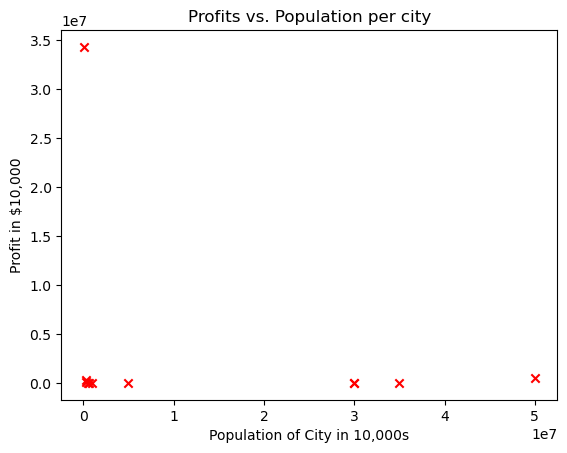

In [126]:
# Plot the linear fit
plt.plot(x_train, predicted, c = "b")

# Create a scatter plot of the data. 
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')

Your final values of $w,b$ can also be used to make predictions on profits. Let's predict what the profit would be in areas of 35,000 and 70,000 people. 

- The model takes in population of a city in 10,000s as input. 

- Therefore, 35,000 people can be translated into an input to the model as `np.array([3.5])`

- Similarly, 70,000 people can be translated into an input to the model as `np.array([7.])`


In [127]:
predict1 = 3.5 * w + b
print('For population = 35,000, we predict a profit of $%.2f' % (predict1*10000))

predict2 = 7.0 * w + b
print('For population = 70,000, we predict a profit of $%.2f' % (predict2*10000))

For population = 35,000, we predict a profit of $nan
For population = 70,000, we predict a profit of $nan
